In [1]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import spectools_ir
print(spectools_ir.__file__)

/Users/belaarwen/opt/anaconda3/lib/python3.9/site-packages/spectools_ir/__init__.py


In [3]:
#hitran_data_CO  = extract_hitran_data('CO',4.6,5.42,vup=1)                
hitran_data_H2O = extract_hitran_data('H2O',4.6,5.42,eupmax=4000,aupmin=0)

In [4]:
convol_fwhm = 30.
au=1.5e11
#Make slab model
#This can take a few seconds to run.  It is primarily limited by the convolution time.
CO_model=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.45,convol_fwhm=convol_fwhm,d_pc=140.,res=1e-5) # play with convol_fwhm (broader for IQ tau?)
water_model=make_spec('H2O',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.45,convol_fwhm=convol_fwhm,d_pc=140.,res=1e-5) # play with convol_fwhm (broader for IQ tau?)

Reading partition function from:  https://hitran.org/data/Q/q26.txt
Reading partition function from:  https://hitran.org/data/Q/q1.txt


In [5]:
water_model['lineparams']

molec_id,local_iso_id,wn,a,elower,Vp_HITRAN,Vpp_HITRAN,Qp_HITRAN,Qpp_HITRAN,gup,glow,nu,eup_k,wave,lineflux,tau_peak,fthin
int32,int32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,float32,float32,float32,float32,float32,float64,float32,float32
1,1,1834.963,0.000513,2181.0898,0 2 0,0 1 0,6 4 2,7 1 7,13.0,15.0,55010810000000.0,5778.204,5.4497013,1.675164062692074e-22,8.337075e-06,1.6751687e-22
1,1,1835.0004,3.126,4184.831,0 2 0,0 1 0,14 4 11,14 3 12,87.0,87.0,55011930000000.0,8661.193,5.44959,3.797799421679973e-19,0.019028002,3.8233867e-19
1,1,1835.4088,2.511e-07,888.6327,0 1 0,0 0 0,7 5 3,6 5 1 q,15.0,13.0,55024172000000.0,3919.2878,5.4483776,6.072371255865402e-25,3.0212824e-08,6.072369e-25
1,1,1835.4254,0.08617,3890.8293,0 1 1,0 0 1,4 3 2,3 0 3,9.0,7.0,55024670000000.0,8238.803,5.448328,1.6636752686323841e-21,8.2777005e-05,1.6637227e-21
1,1,1835.4677,4.914,4622.9062,1 1 0,1 0 0,9 3 7,8 2 6,19.0,17.0,55025940000000.0,9292.158,5.4482026,6.977201889399383e-20,0.0034756146,6.9857755e-20
1,1,1835.4866,2.34e-08,416.2087,0 1 0,0 0 0,5 4 2,5 2 4 q,11.0,11.0,55026504000000.0,3239.687,5.448147,8.188308004861742e-26,4.0738577e-09,8.188306e-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,1,2182.3528,0.004925,3323.2698,0 2 0,0 1 0,11 6 6,11 3 9,23.0,23.0,65425290000000.0,7921.3613,4.5822105,3.9688531983640467e-22,1.6766073e-05,3.9688786e-22
1,1,2182.6067,2.167e-07,1477.2974,0 1 0,0 0 0,11 5 6,9 5 4 q,69.0,57.0,65432904000000.0,5265.7847,4.5816774,7.4575213115772695e-25,3.1500832e-08,7.457524e-25


In [5]:
lineflux_data=pickle.load(open('lineflux_data.p','rb'))  #restore lineflux_data if you don't want to re-run

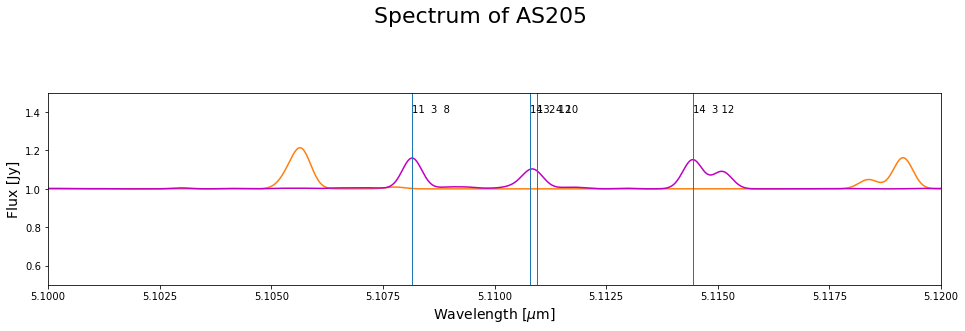

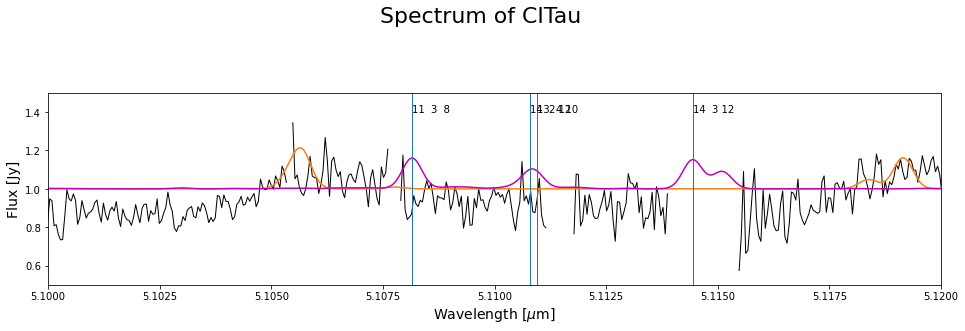

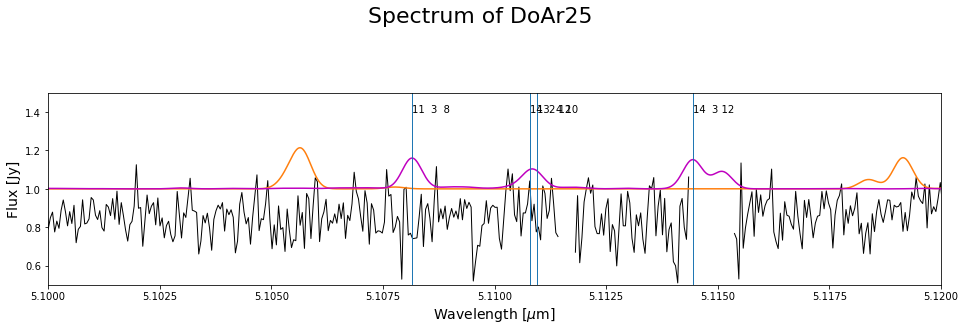

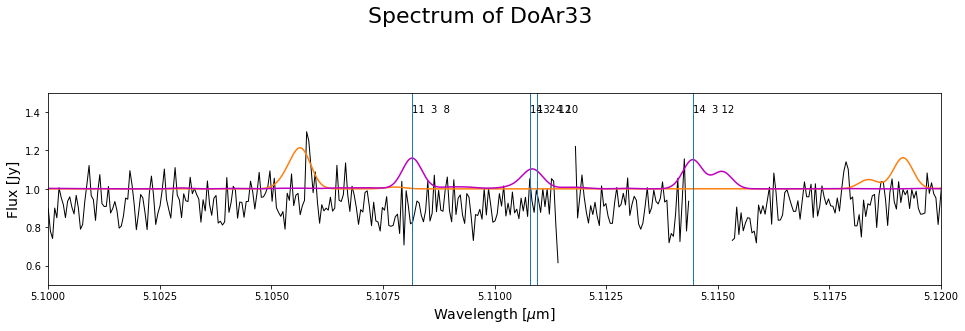

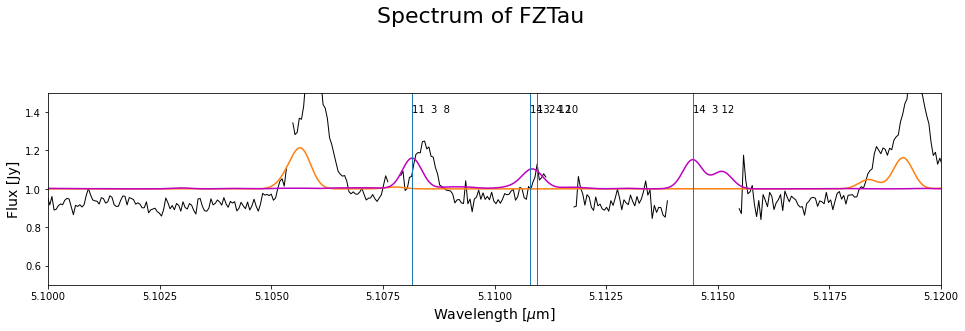

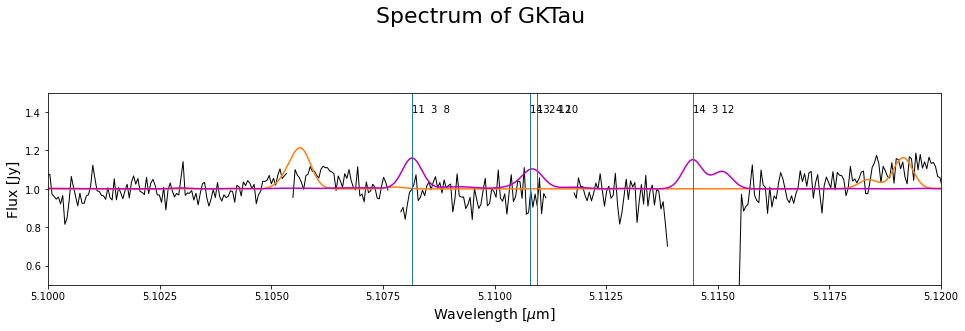

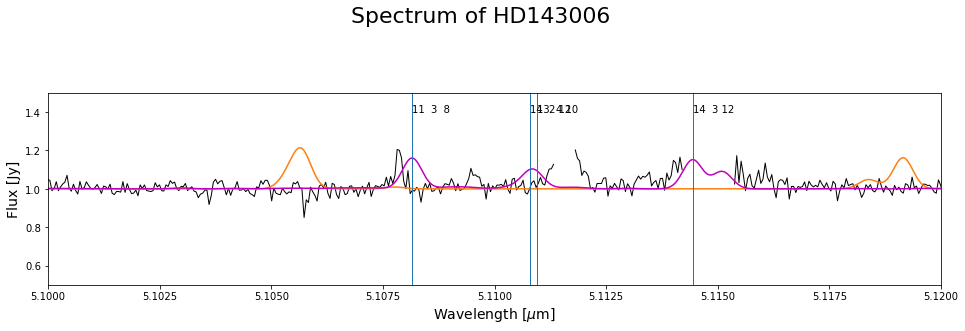

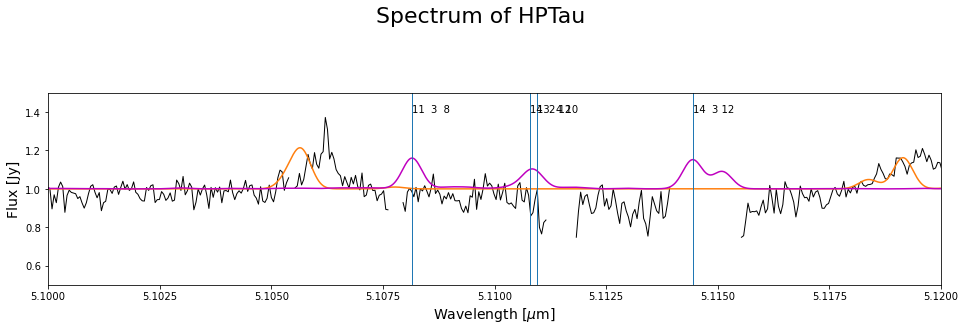

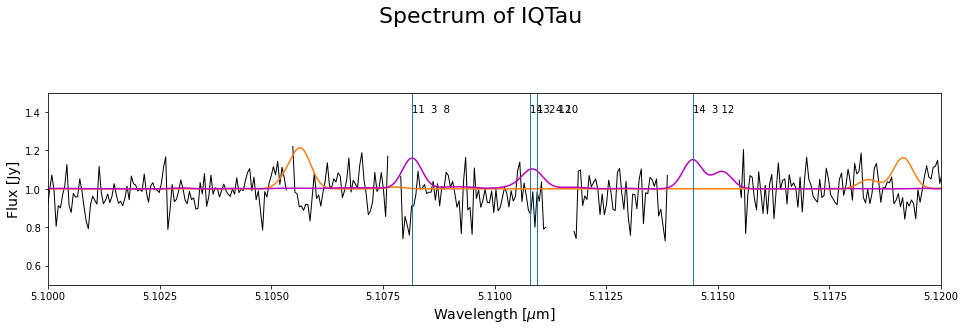

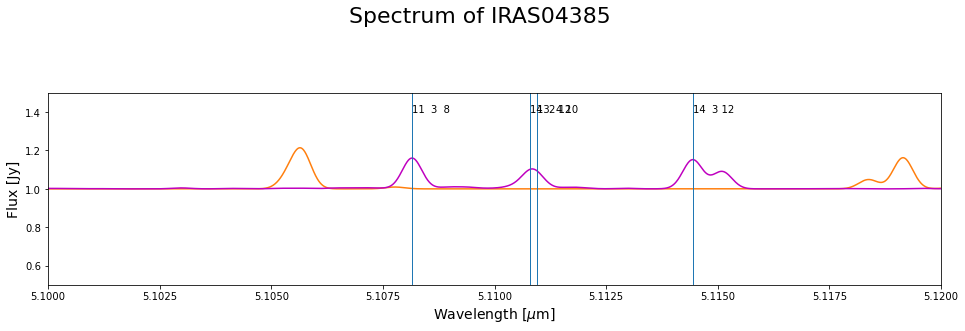

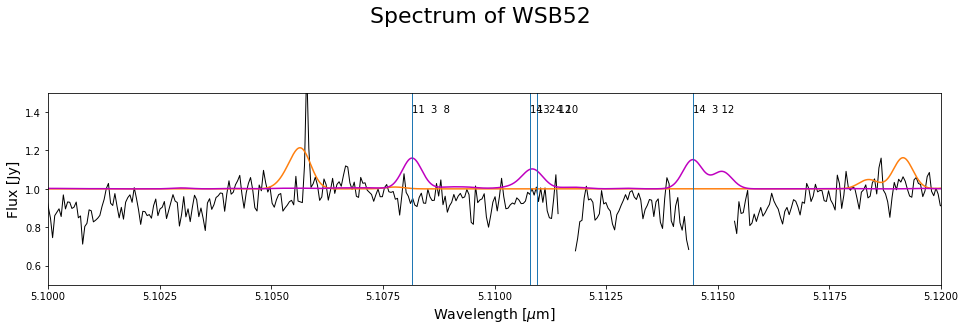

In [8]:
sources_list = ['AS205','CITau','DoAr25','DoAr33','FZTau','GKTau','HD143006','HPTau','IQTau','IRAS04385','WSB52']

for i in sources_list:
    infile  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+i+'_orders.fits'
    hdulist = fits.open(infile)      #hdu means header data unit so we are creating a list of header data units to use in further files
    data    = hdulist[1].data
    wave    = data['wave']
    flux    = data['flux']
    
    fig = plt.figure(figsize = (16,12))
    fig.suptitle('Spectrum of ' +i, fontsize = 22)

    doppler_shift = 0.0000#29073304690986737
    
    ax1 = fig.add_subplot(311)
    ax1.plot(wave+doppler_shift,flux, linewidth=1, color='k')
    ax1.plot(CO_model['spectrum']['wave']+doppler_shift,CO_model['spectrum']['convolflux']+1,label='Convolved CO Model Spectrum',color='C1')
    ax1.plot(water_model['spectrum']['wave']+doppler_shift,water_model['spectrum']['convolflux']+1,label='Convolved H20 Model Spectrum',color='m')
    ax1.set_xlim(5.1, 5.12)
    #for i,lam in enumerate(hitran_data_CO['wave']):
    #    if((lam>5.12) & (lam<5.13)):
    #        ax1.axvline(lam, linewidth=1, color='tab:red') 
    for i,lam in enumerate(water_model['lineparams']['wave']):
        if((lam>5.1) & (lam<5.12) & (water_model['lineparams']['eup_k'][i]>4000) & (water_model['lineparams']['tau_peak'][i]>0.1)):
            ax1.axvline(lam, linewidth=1, color='tab:blue') 
            ax1.text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
    ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
    ax1.set_ylabel('Flux [Jy]', fontsize=14)
    ax1.set_ylim(0.5, 1.5)

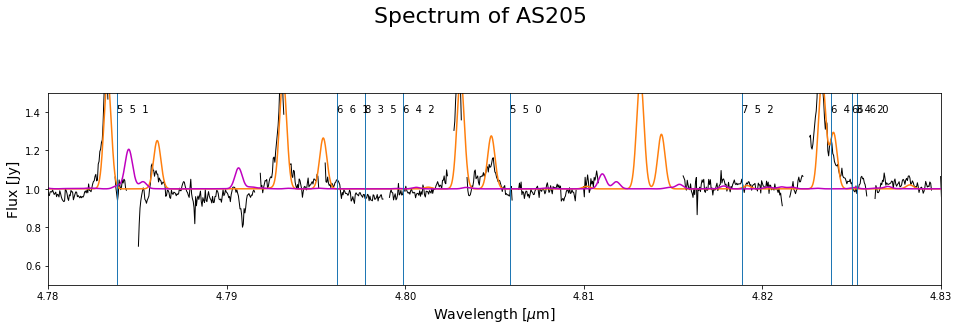

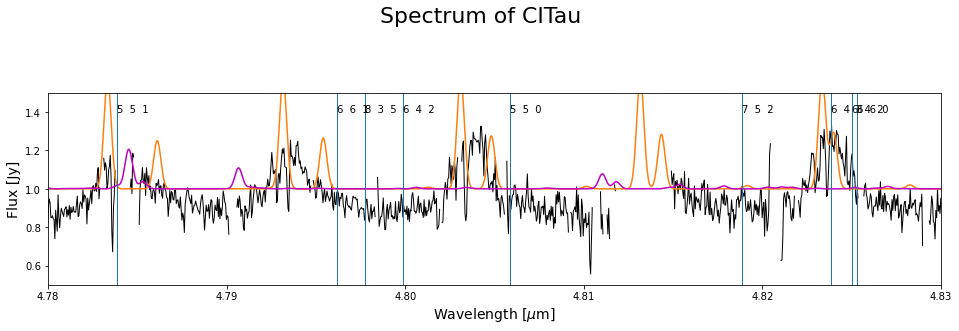

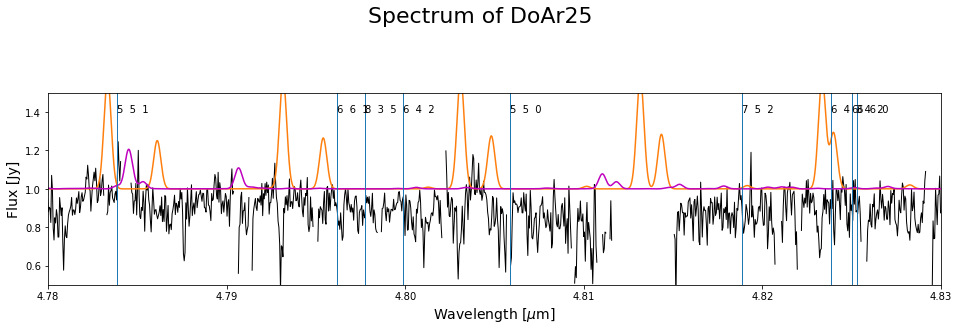

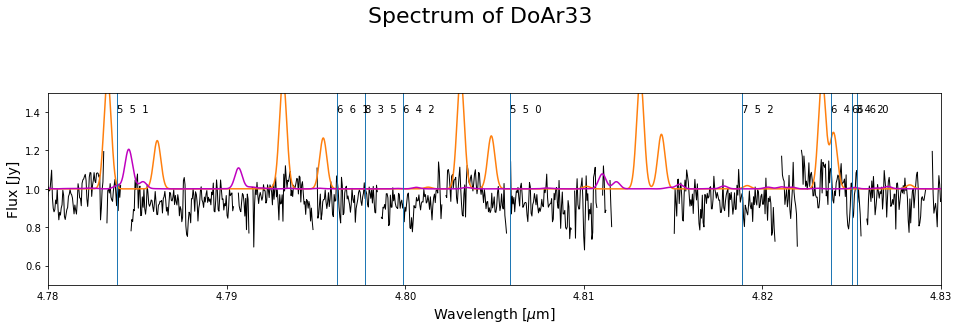

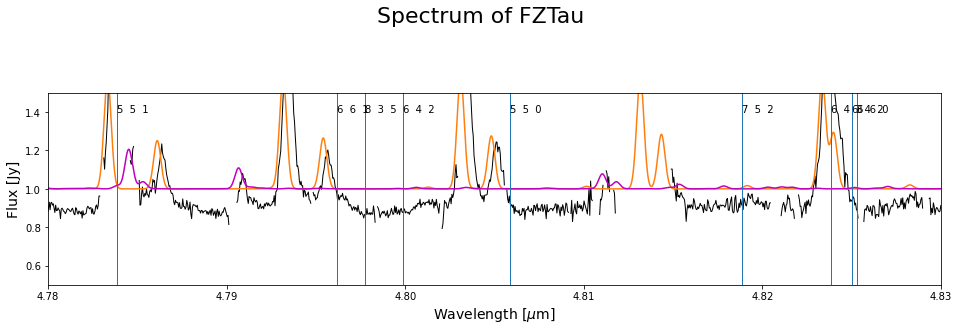

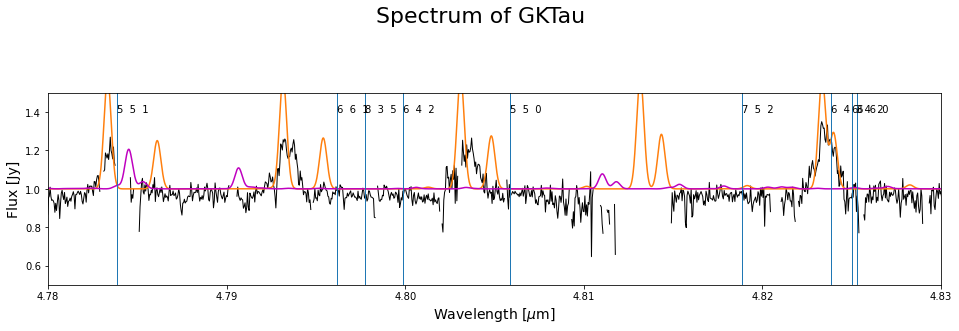

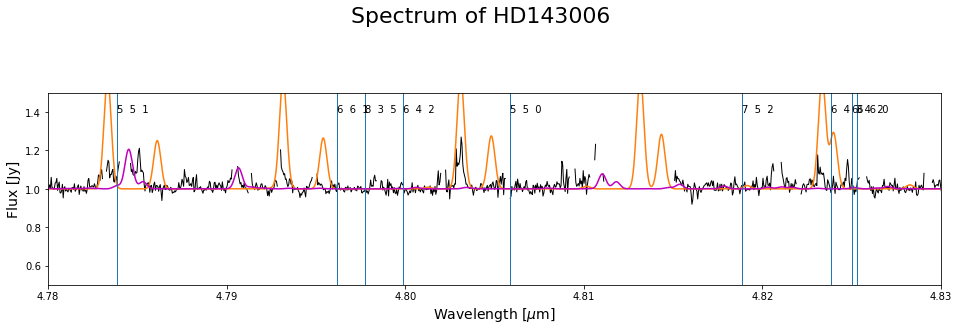

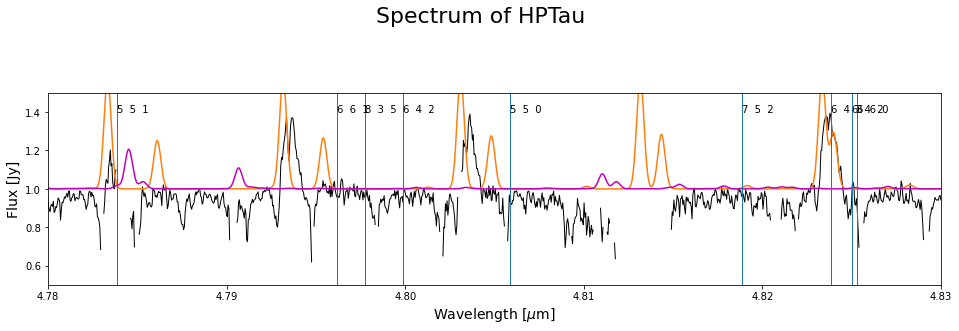

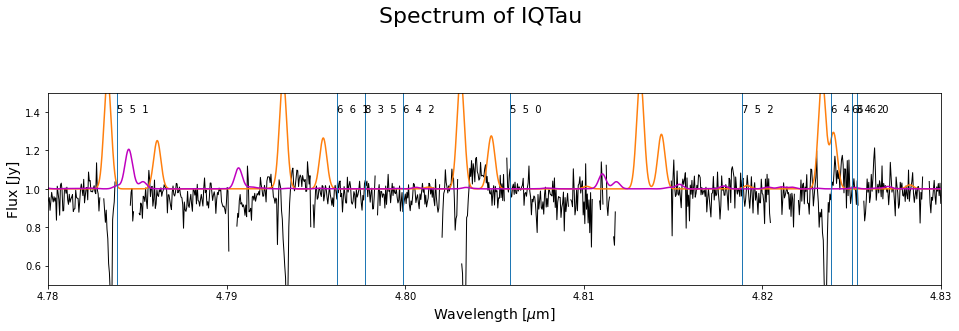

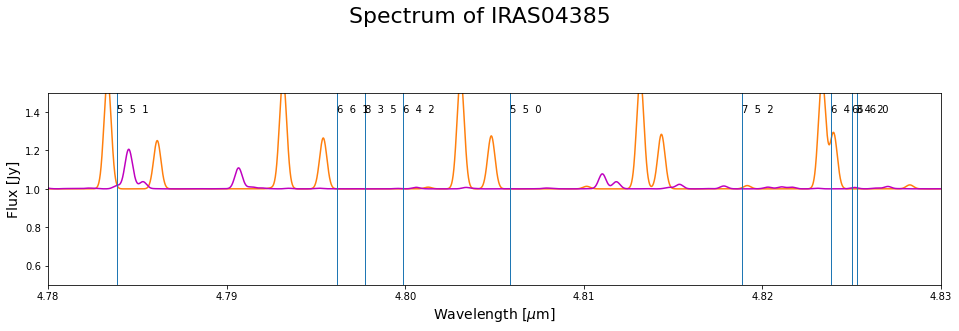

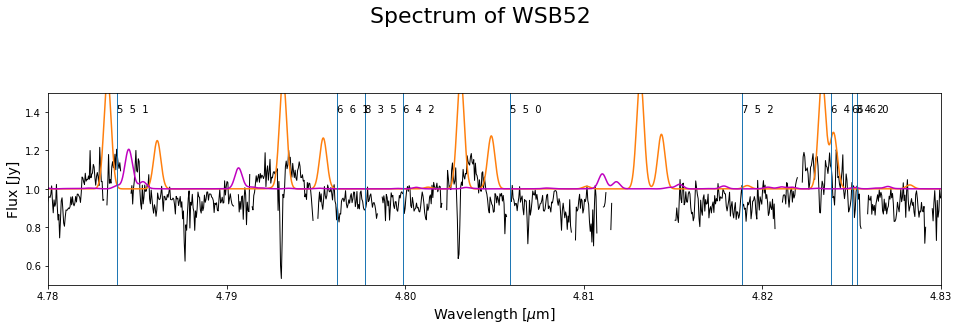

In [49]:
sources_list = ['AS205','CITau','DoAr25','DoAr33','FZTau','GKTau','HD143006','HPTau','IQTau','IRAS04385','WSB52']

for i in sources_list:
    infile  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+i+'_orders.fits'
    hdulist = fits.open(infile)      #hdu means header data unit so we are creating a list of header data units to use in further files
    data    = hdulist[1].data
    wave    = data['wave']
    flux    = data['flux']
    
    fig = plt.figure(figsize = (16,12))
    fig.suptitle('Spectrum of ' +i, fontsize = 22)

    doppler_shift = 0.000029073304690986737
    
    ax1 = fig.add_subplot(311)
    ax1.plot(wave+doppler_shift,flux, linewidth=1, color='k')
    ax1.plot(CO_model['spectrum']['wave']+doppler_shift,CO_model['spectrum']['convolflux']+1,label='Convolved CO Model Spectrum',color='C1')
    ax1.plot(water_model['spectrum']['wave']+doppler_shift,water_model['spectrum']['convolflux']+1,label='Convolved H20 Model Spectrum',color='m')
    ax1.set_xlim(4.78, 4.83)
    #for i,lam in enumerate(hitran_data_CO['wave']):
    #    if((lam>5.12) & (lam<5.13)):
    #        ax1.axvline(lam, linewidth=1, color='tab:red') 
    for i,lam in enumerate(hitran_data_H2O['wave']):
        if((lam>4.78) & (lam<4.83)):
            ax1.axvline(lam, linewidth=1, color='tab:blue') 
            ax1.text(hitran_data_H2O['wave'][i],1.4,hitran_data_H2O['Qp'][i].strip())
    ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
    ax1.set_ylabel('Flux [Jy]', fontsize=14)
    ax1.set_ylim(0.5, 1.5)

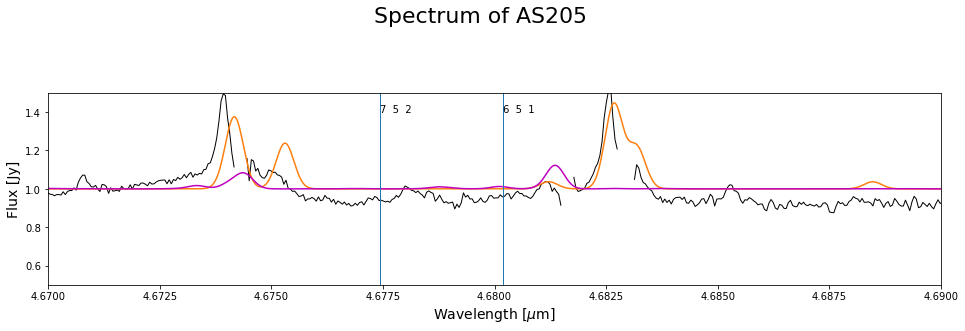

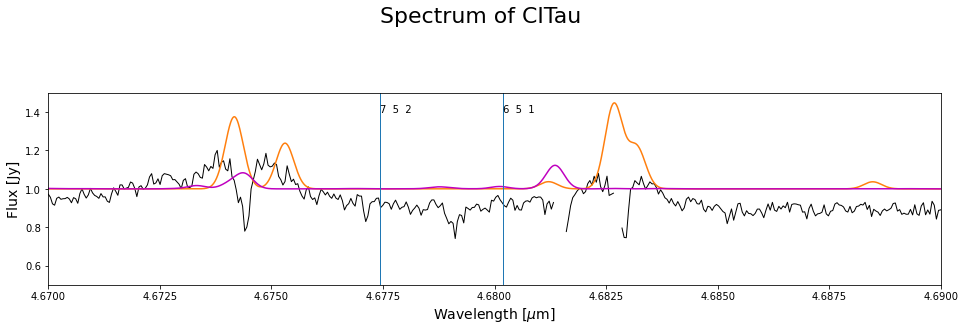

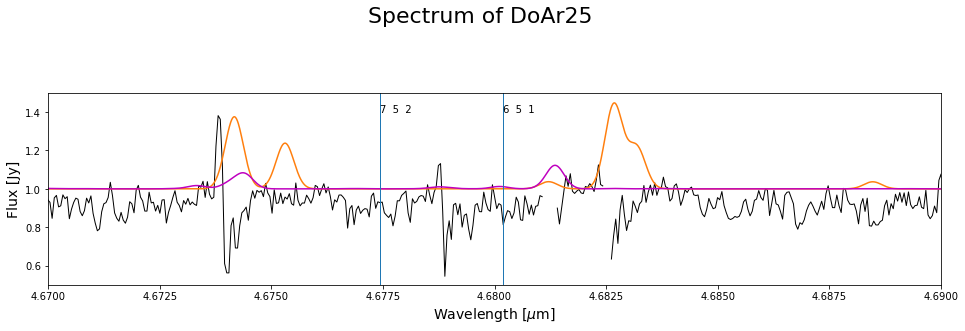

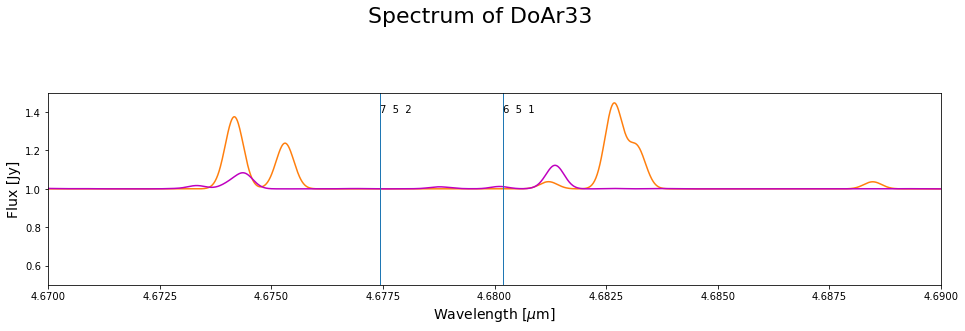

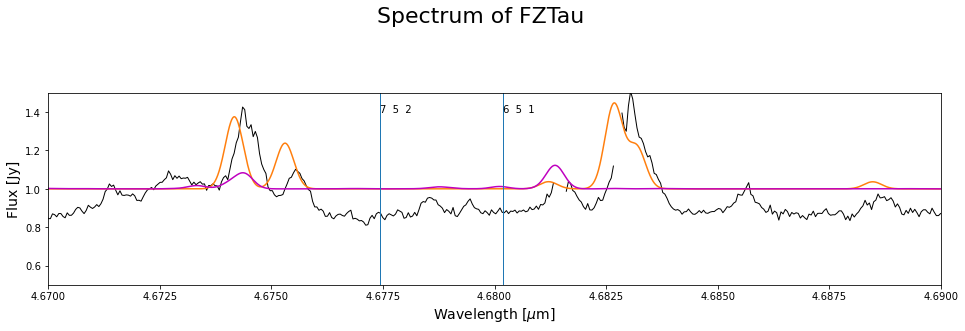

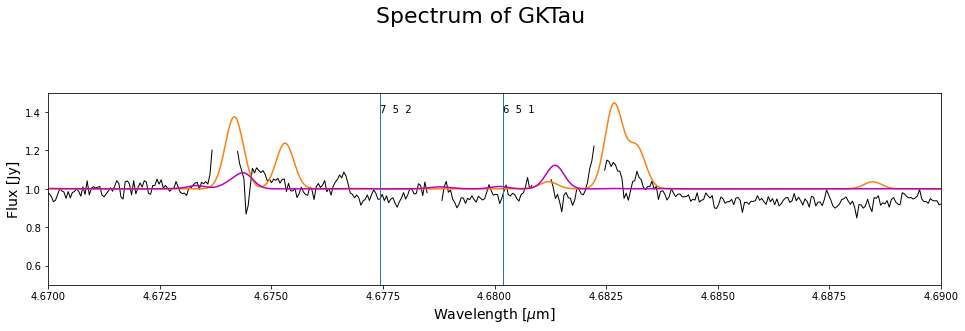

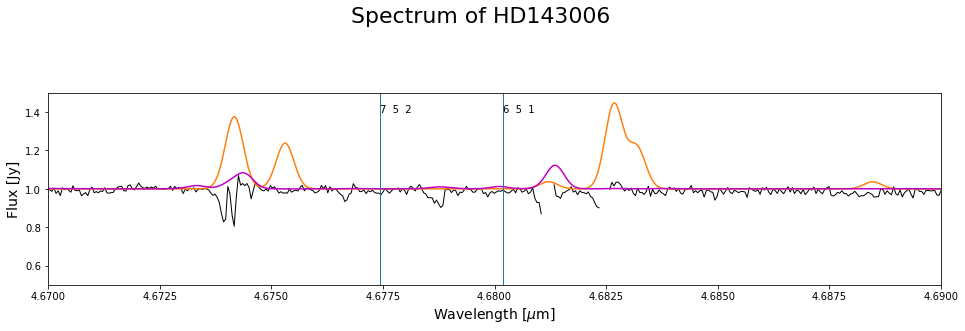

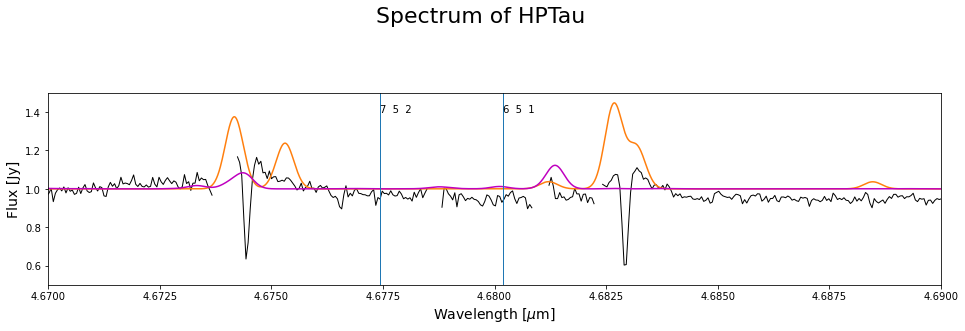

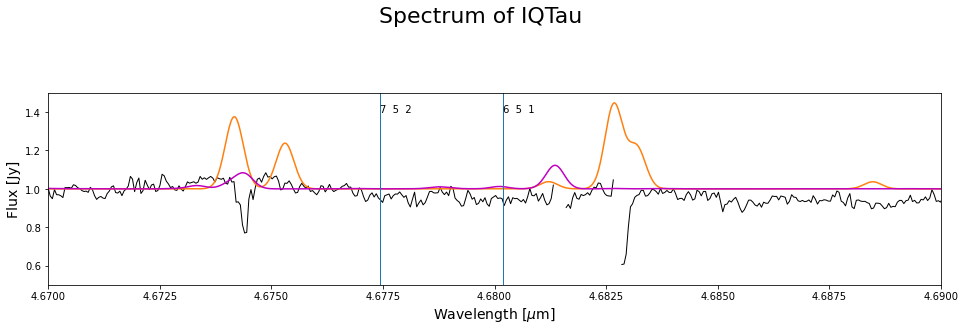

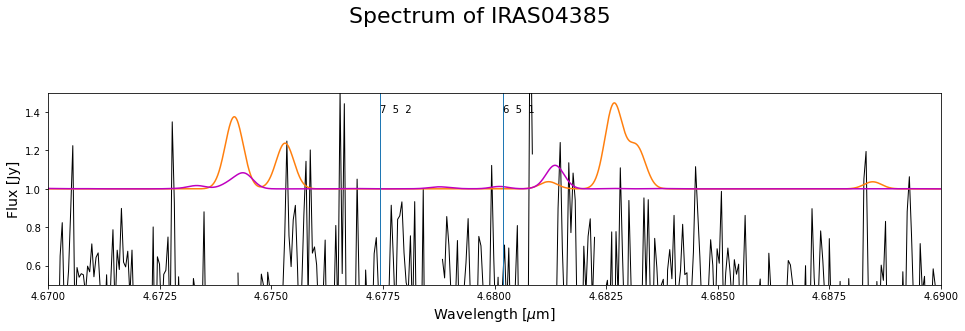

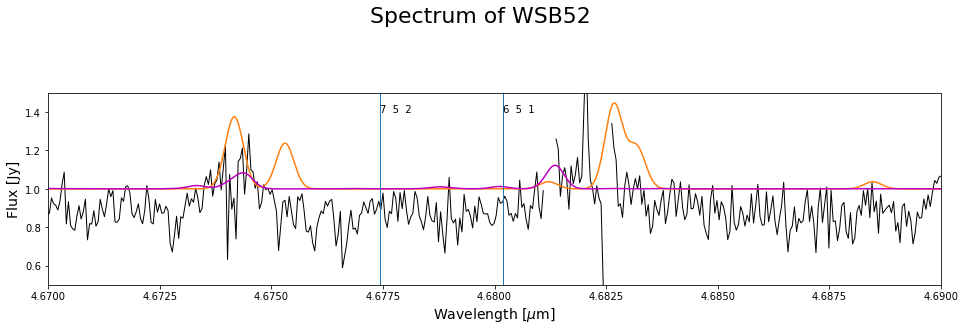

In [12]:
sources_list = ['AS205','CITau','DoAr25','DoAr33','FZTau','GKTau','HD143006','HPTau','IQTau','IRAS04385','WSB52']

for i in sources_list:
    infile  = '/Users/belaarwen/Desktop/Vassar/Astronomy/Thesis/reducs22/'+i+'_orders.fits'
    hdulist = fits.open(infile)      #hdu means header data unit so we are creating a list of header data units to use in further files
    data    = hdulist[1].data
    wave    = data['wave']
    flux    = data['flux']
    
    fig = plt.figure(figsize = (16,12))
    fig.suptitle('Spectrum of ' +i, fontsize = 22)

    doppler_shift = 0.000029073304690986737
    
    ax1 = fig.add_subplot(311)
    ax1.plot(wave+doppler_shift,flux, linewidth=1, color='k')
    ax1.plot(CO_model['spectrum']['wave']+doppler_shift,CO_model['spectrum']['convolflux']+1,label='Convolved CO Model Spectrum',color='C1')
    ax1.plot(water_model['spectrum']['wave']+doppler_shift,water_model['spectrum']['convolflux']+1,label='Convolved H20 Model Spectrum',color='m')
    ax1.set_xlim(4.67, 4.69)
    #for i,lam in enumerate(hitran_data_CO['wave']):
    #    if((lam>5.12) & (lam<5.13)):
    #        ax1.axvline(lam, linewidth=1, color='tab:red') 
    for i,lam in enumerate(hitran_data_H2O['wave']):
        if((lam>4.67) & (lam<4.69)):
            ax1.axvline(lam, linewidth=1, color='tab:blue') 
            ax1.text(hitran_data_H2O['wave'][i],1.4,hitran_data_H2O['Qp'][i].strip())
    ax1.set_xlabel('Wavelength [$\mu$m]', fontsize=14)
    ax1.set_ylabel('Flux [Jy]', fontsize=14)
    ax1.set_ylim(0.5, 1.5)

## There seems to be a feature in CITau, FKTau, HD143006 and possibly one in GKTau. 

DoAr25, DoAr33, HPTAU, IQTau and WSB52 have no discernable feature.

IRAS04385 and AS205 have no spectrum in this regime.

In [45]:
water_model['lineparams']['Vp_HITRAN']

0 2 0
0 2 0
0 1 0
0 1 1
1 1 0
0 1 0
0 2 0
0 1 0
0 0 1
...
0 1 0


In [35]:
water_modelv

molec_id,local_iso_id,wn,a,elower,Vp_HITRAN,Vpp_HITRAN,Qp_HITRAN,Qpp_HITRAN,gup,glow,nu,eup_k,wave,lineflux,tau_peak,fthin
int32,int32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,float32,float32,float32,float32,float32,float64,float32,float32
1,1,1834.963,0.000513,2181.0898,0 2 0,0 1 0,6 4 2,7 1 7,13.0,15.0,55010810000000.0,5778.204,5.4497013,1.675164062692074e-22,8.337075e-06,1.6751687e-22
1,1,1835.0004,3.126,4184.831,0 2 0,0 1 0,14 4 11,14 3 12,87.0,87.0,55011930000000.0,8661.193,5.44959,3.797799421679973e-19,0.019028002,3.8233867e-19
1,1,1835.4088,2.511e-07,888.6327,0 1 0,0 0 0,7 5 3,6 5 1 q,15.0,13.0,55024172000000.0,3919.2878,5.4483776,6.072371255865402e-25,3.0212824e-08,6.072369e-25
1,1,1835.4254,0.08617,3890.8293,0 1 1,0 0 1,4 3 2,3 0 3,9.0,7.0,55024670000000.0,8238.803,5.448328,1.6636752686323841e-21,8.2777005e-05,1.6637227e-21
1,1,1835.4677,4.914,4622.9062,1 1 0,1 0 0,9 3 7,8 2 6,19.0,17.0,55025940000000.0,9292.158,5.4482026,6.977201889399383e-20,0.0034756146,6.9857755e-20
1,1,1835.4866,2.34e-08,416.2087,0 1 0,0 0 0,5 4 2,5 2 4 q,11.0,11.0,55026504000000.0,3239.687,5.448147,8.188308004861742e-26,4.0738577e-09,8.188306e-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,1,2182.3528,0.004925,3323.2698,0 2 0,0 1 0,11 6 6,11 3 9,23.0,23.0,65425290000000.0,7921.3613,4.5822105,3.9688531983640467e-22,1.6766073e-05,3.9688786e-22
1,1,2182.6067,2.167e-07,1477.2974,0 1 0,0 0 0,11 5 6,9 5 4 q,69.0,57.0,65432904000000.0,5265.7847,4.5816774,7.4575213115772695e-25,3.1500832e-08,7.457524e-25


In [38]:
water_model['spectrum']

wave,flux,convolflux,totaltau
micron,Jy,Jy,
float64,float64,float64,float64
4.58,0.0,0.0,0.0
4.58001,0.0,0.0,0.0
4.58002,0.0,0.0,0.0
4.58003,0.0,2.8820258772365496e-19,0.0
4.58004,0.0,1.7911428975946513e-16,0.0
4.58005,0.0,3.773594954684649e-14,0.0
...,...,...,...
5.44994,0.0,0.0020793634138831308,1.0851192956984397e-86
